# We implement a Kalman Filter on a double integrator $\ddot{x} = a + v$ with GPS measurements $z = x + w$
We follow https://www.intechopen.com/books/introduction-and-implementations-of-the-kalman-filter/introduction-to-kalman-filter-and-its-applications section 2

This is a good paper for learning the theory and implementation, but honestly I find they chose very poor parameters which make the estimation problem trivial anyways...

\begin{align}
x_{k+1} = \pmatrix{ p_{k+1} \\ v_{k+1}} 
&= \pmatrix{ p_k + v_k \Delta t + \frac{1}{2} a_k \Delta t^2 \\ v_k + a_k \Delta t} \\
&= \pmatrix{ I_{3 \times 3} & I_{3 \times 3} \Delta t \\ 0 & I_{3 \times 3}} \pmatrix{ p_k \\ v_k} +
   \pmatrix{ \frac{1}{2} I_{3 \times 3} \Delta t^2 \\  I_{3 \times 3} \Delta t} a_k \\
&= Ax_k + Ba_k
\end{align}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dymoesco.estimation.filters import KalmanFilter
from dymoesco.dynamics.doubleintegrator import DoubleIntegrator
np.set_printoptions(suppress=True, precision=3)

In [85]:
# PARAMS
a_std = 0.3
p_std = 3
v_std = 0.03

x0 = np.array([2,-2,0,5,5.1,0.1])
P0 = np.block([[np.eye(3) * 4**2, np.zeros((3,3))],
               [np.zeros((3,3)), np.eye(3) * 0.4**2]])
dt = 1
N = 20
dims = ["$p_x$", "$p_y$", "$p_z$", "$v_x$", "$v_y$", "$v_z$"]

In [86]:
# Building the Kalman Filter
Q = np.block([[1/4 * dt**4 * np.eye(3), 1/2 * dt**3 * np.eye(3)],
              [1/2 * dt**3 * np.eye(3), dt**2 * np.eye(3)]])
R = a_std**2 *np.block([[np.eye(3) * p_std**2, np.zeros((3,3))],
                        [np.zeros((3,3)), np.eye(3) * v_std**2]])
A = np.block([[np.eye(3), np.eye(3)*dt],
              [np.zeros((3,3)), np.eye(3)]])
B = np.block([[1/2 * np.eye(3) * dt**2],
              [np.eye(3) * dt]])
C = np.eye(6)
kf = KalmanFilter(A,B,C,Q,R)

In [87]:
# Generate ground truth trajectory
di = DoubleIntegrator(dim=3)
def u(t):
    return np.random.normal(0, a_std, 3)

x0 = [0,0,0,5,5,0]
t_span = (0,N)
sol = di.simulate(u, t_span, x0, t_eval=np.arange(0,N,dt))

In [88]:
# KF prediction only
preds = np.zeros((N,6))
preds[0] = x0
x = x0; P = P0;
for i in range(1,20):
    x, P = kf.predict(x, P, np.zeros(3))
    preds[i] = x

In [89]:
# Generate noisy observations
x = sol.y
p_obs_noise = np.random.normal(0, p_std, (3,N))
v_obs_noise = np.random.normal(0, v_std, (3,N))
obs_noise = np.vstack([p_obs_noise, v_obs_noise])
obs = x + obs_noise

In [90]:
# KF with pred + update
filtered = np.zeros((N,6))
filtered[0] = x0
x = x0; P = P0;
for i in range(1,20):
    x, P = kf.predict(x, P, np.zeros(3))
    x, P = kf.update(x, P, obs.T[i])
    filtered[i] = x

In [91]:
from ipywidgets import interact
@interact(ground_truth=True, observation=True, pred=False, pred_and_update=False)
def f(ground_truth, observation, pred, pred_and_update):
    fig, axes = plt.subplots(1,2)
    for i, ax in enumerate(axes):
        ax.set_title(dims[i])
        if ground_truth:
            ax.plot(sol.y[i], label="ground_truth")
        if observation:
            ax.scatter(range(20), obs[i], label="observations")
        if pred:
            ax.plot(preds.T[i], label="pred only")
        if pred_and_update:
            ax.plot(filtered.T[i], label="pred+update")
        ax.legend()

interactive(children=(Checkbox(value=True, description='ground_truth'), Checkbox(value=True, description='obse…

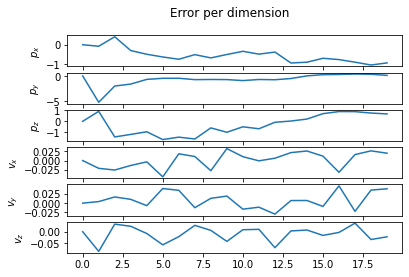

In [92]:
# This is figure 1 from the paper
err = filtered.T - sol.y
fig, axes = plt.subplots(6,1)
fig.suptitle("Error per dimension")
for i,ax in enumerate(axes):
    ax.plot(err[i])
    ax.set_ylabel(dims[i])